Remember to

```sh
sudo apt install ffmpeg libavcodec-extra
```

In [29]:
# # Download model checkpoints:
# import torch

# # dinov2_vits14_reg_lc = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitb14_reg_lc')
# dinov2_vits14_reg_lc = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitb14_lc')

# # Then move ckpt to dinov2/checkpoints

In [30]:

import sys
import os
import torch
import torch.nn.functional as F
import numpy as np
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt

if 'dinov2' in sys.modules:
    del sys.modules['dinov2']
    
# Get the absolute path of the project root
project_root = os.path.abspath("..")  # Adjust path if your notebook is deeper in directories

# Add project root to sys.path
sys.path.insert(0, project_root)

# sys.path.append(project_root)

    
# Now you can import dinov2
import dinov2
print("Currently using dinov2 from:", dinov2.__file__)



from dinov2.eval.setup import build_model_for_eval
from dinov2.configs import load_and_merge_config
from dinov2.utils.visualize import print_video_model_stats, load_and_preprocess_video, get_model_output, \
    two_stage_pca, compute_cosine_similarity, save_triple_image, plot_videos, plot_distance_chart

device = "cuda"
device = torch.device(device if torch.cuda.is_available() else "cpu")
print(device)

Currently using dinov2 from: /scorpio/home/luyukuan/projects/dinov2/dinov2/__init__.py
cuda


Load dinov2 (with registers) model

In [31]:
model_size = "s"
with_registers = "_reg4" # "_reg4"
# Use `dinov2_vits14_pretrain`
conf = load_and_merge_config(f'eval/vit{model_size}14{with_registers}_pretrain')
model = build_model_for_eval(conf, f'../dinov2/checkpoints/dinov2_vit{model_size}14{with_registers}_pretrain.pth')
# model = build_model_for_eval(conf, f'../dinov2/checkpoints/dinov2_vit{model_size}14_pretrain.pth')

THRESHOLD = 0.2


In [32]:
from numpy import ndarray


def compute_distance_in_feature_space(video1, video2, model, device, threshold=0.6):
    B, C, H, W, patch_size, embedding_dim, patch_num = print_video_model_stats(video1, model)
    
    # Get cls token embedding and patch token embeddings
    cls_token_emb1, patch_token_embs1 = get_model_output(model, video1)
    cls_token_emb2, patch_token_embs2 = get_model_output(model, video2)
    
     # Calculate similarity
     # Each cls token embedding is of shape (B, D) where B is the video length
    similarities = compute_cosine_similarity(cls_token_emb1, cls_token_emb2)
    normalized_distances = list(map(lambda sim: (1 - sim)/2, similarities))
    return normalized_distances

def plot(img1: np.ndarray, img2: np.ndarray, distance: float, output_path=None):
    """
    Plots two images side by side with the computed distance displayed as a title.

    Parameters:
        img1 (np.ndarray): The first image (original).
        img2 (np.ndarray): The second image (covered).
        distance (float): The computed distance between the two images.
        output_path (str, optional): Path to save the plot. If None, the plot is displayed.
    """
    # Create figure with stacked images (one above the other)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 12))

    ax1.imshow(img1)
    ax1.set_title("Original")
    ax1.axis('off')
    
    ax2.imshow(img2)
    ax2.set_title("Covered")
    ax2.axis('off')
    
    plt.suptitle(f"Distance: {distance:.6f}", fontsize=16)
    plt.tight_layout()
    
    # Save or display the figure
    if output_path:
        plt.savefig(output_path, dpi=150, bbox_inches='tight')
        plt.close()
    else:
        plt.show()


Video FPS: 20.00, Total Frames: 102, Duration: 5.10 seconds
Video FPS: 20.00, Total Frames: 102, Duration: 5.10 seconds
Input tensor shape: Batch=102, Channels=3, Height=448, Width=448
Patch size: 14
Embedding dimension: 384
Number of patches of each image: 1024


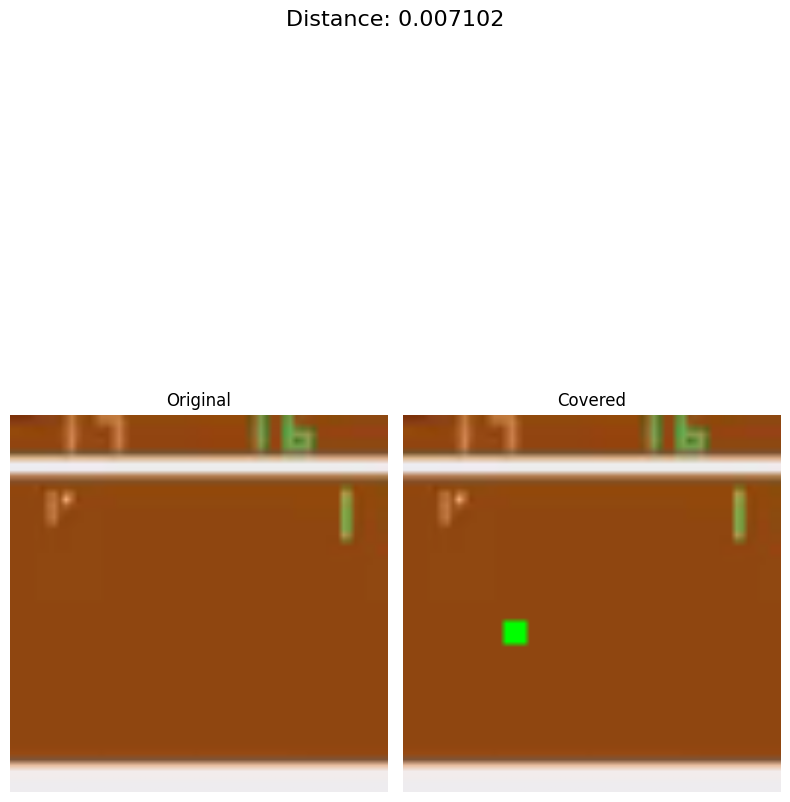

Distance at frame 0: 0.007102489471435547


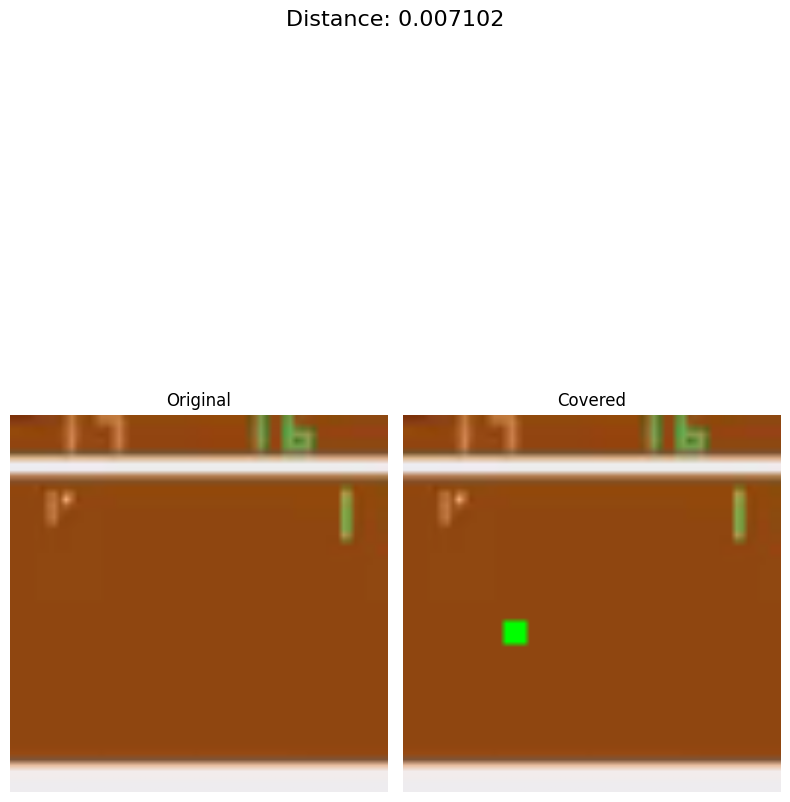

Distance at frame 1: 0.007102489471435547


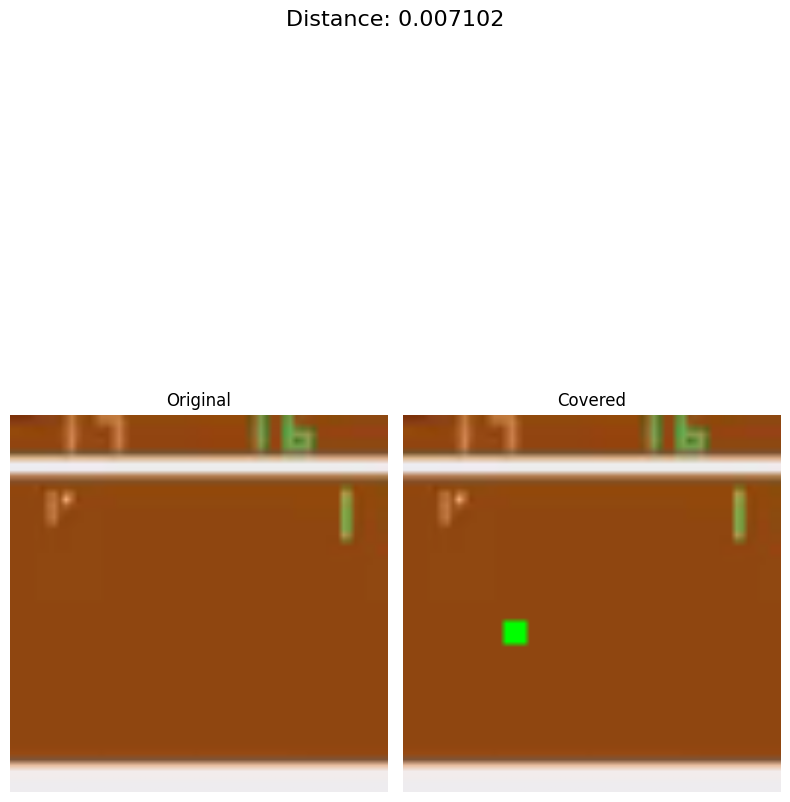

Distance at frame 2: 0.007102489471435547


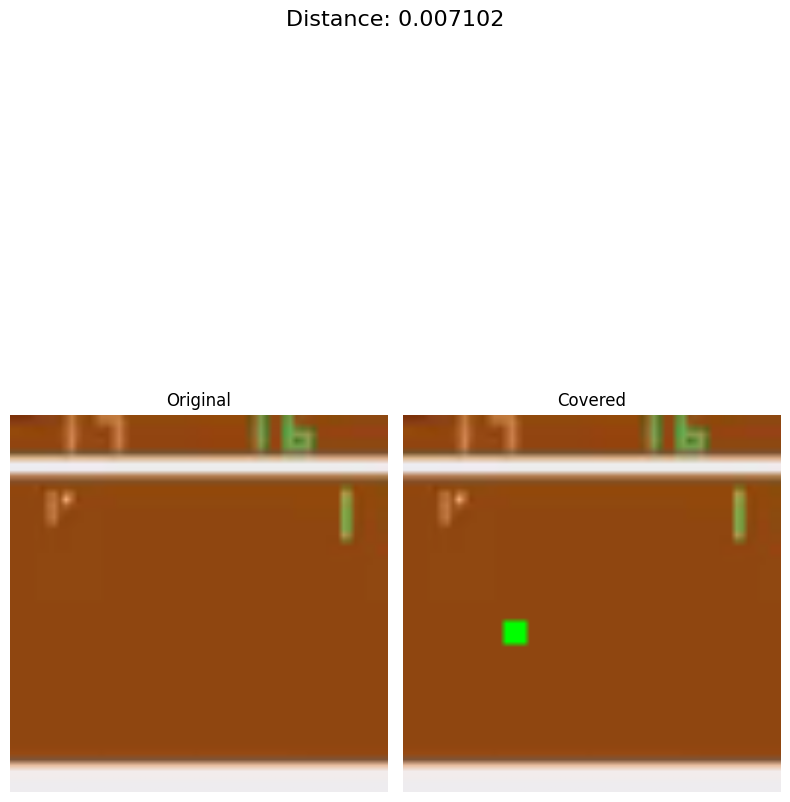

Distance at frame 3: 0.007102489471435547


In [33]:
base_dir = "./data/pong/videos"
video1_name, video2_name = "pong", "pong"
video1_path, video2_path = os.path.join(base_dir, f"{video1_name}.avi"), os.path.join(base_dir, f"{video2_name}.avi")
output_dir = "./data/pong/plots/"
os.makedirs(output_dir, exist_ok=True)

from dinov2.utils.visualize import colorize_area
colorize_video2_hook = lambda video: colorize_area(video, color=[0, 255, 0], starting_location=(35, 17), width=4, height=4)  # Change the pixel at (0, 0) to black

video1_prenorm, video1_normalized, fps = load_and_preprocess_video(video1_path, target_size=448*1, patch_size = model.patch_size)# 448 is multiples of patch_size (14)
video2_prenorm, video2_normalized, fps = load_and_preprocess_video(video2_path, target_size=448*1, patch_size = model.patch_size, hook_function=colorize_video2_hook)# 448 is multiples of patch_size (14)


distance_list = compute_distance_in_feature_space(video1_prenorm, video2_prenorm, model, device)

video1_prenorm = video1_prenorm.permute(0, 2, 3, 1).cpu().numpy()  # Change to (T, H, W, C)
video2_prenorm = video2_prenorm.permute(0, 2, 3, 1).cpu().numpy()  # Change to (T, H, W, C)
T, H, W, C = video1_prenorm.shape

for t in range(T):
    if t > 3:
        break
    frame1, frame2 = video1_prenorm[t], video2_prenorm[t]
    distance = distance_list[t]
    
    plot(frame1, frame2, distance, output_path=None)
    print(f"Distance at frame {t}: {distance}")



In [34]:


plot_videos(video1_prenorm, video2_prenorm, distance_list, output_path=os.path.join(output_dir, f"{video2_name}.mp4"), fps=fps)
plot_distance_chart(distance_list, title="Frame-by-Frame Distance", output_path=os.path.join(output_dir, f"{video2_name}.png"))
avg_distance = np.mean(distance_list)
print(f"Average distance: {avg_distance:.6f}")

Average distance: 0.005283


## Model Analysis: Size S with Registers

### Distance Measurements Between Original and Modified Videos

| Video 1 | Video 2 | Distance AVG (normalized img) | Distance AVG (unnormalized img) |
|---------|---------|-------------------------------|--------------------------------|
| Original | No ball | -- | 0.0039 |
| Original | No left paddle | -- | 0.0046 |
| Original | No right paddle | -- | 0.0067 |
| Original | No white bar | -- | 0.0409 |
| Original | Add a small 4×4 white area | -- | 0.0146 |
| Original | Add a small 4×4 red area | -- | 0.0026 |
| Original | Add a small 4×4 green area | -- | 0.0071 |

| Original | Add a small 2×2 white area | -- | 0.0068 |
| Original | Add one white pixel | -- | 0.0081 |
| Original | Add one red pixel | -- | 0.0006 |
| Original | Add one green pixel | -- | 0.0007 |

**Note:** The base distance resulting from MP4 conversion is 0.0112.

- A small pixel region can be less important than the ball (0.0006 < 0.0039 and 0.0026 < 0.0039)
- The importance ranking from most to least significant:
  1. White bar (0.0409)
  2. Right paddle (0.0067)
  3. Left paddle (0.0046)
  4. Ball (0.0039) ~= Small pixel regions



In [35]:
# import cv2
# import numpy as np
# import os

# def read_video_to_numpy(video_path):
#     """读取视频文件到NumPy数组"""
#     cap = cv2.VideoCapture(video_path)
#     if not cap.isOpened():
#         raise ValueError(f"无法打开视频: {video_path}")
    
#     frames = []
#     while True:
#         ret, frame = cap.read()
#         if not ret:
#             break
#         frames.append(frame)  # 保持BGR格式
    
#     cap.release()
#     return np.array(frames)

# def save_numpy_to_lossless_video(video_array, output_path, fps=30.0):
#     """将NumPy数组保存为无损视频"""
#     # 确保输出目录存在
#     output_dir = os.path.dirname(os.path.abspath(output_path))
#     if output_dir and not os.path.exists(output_dir):
#         os.makedirs(output_dir, exist_ok=True)
    
#     # 获取视频尺寸
#     height, width = video_array.shape[1:3]
    
#     # 使用FFV1编解码器(完全无损)
#     fourcc = cv2.VideoWriter_fourcc('F', 'F', 'V', '1')
    
#     # 创建VideoWriter对象，使用.avi容器
#     out_path = output_path if output_path.endswith('.avi') else output_path.rsplit('.', 1)[0] + '.avi'
#     out = cv2.VideoWriter(out_path, fourcc, fps, (width, height), isColor=True)
    
#     if not out.isOpened():
#         raise ValueError(f"无法创建视频写入器，请确保安装了正确的编解码器")
    
#     # 写入每一帧
#     for frame in video_array:
#         out.write(frame)
    
#     out.release()
#     print(f"无损视频已保存到: {out_path}")
#     return out_path

# def save_numpy_to_lossy_video(video_array, output_path, fps=30.0, quality=95):
#     """
#     将NumPy数组保存为有损压缩的MP4视频
    
#     参数:
#         video_array: 视频帧的NumPy数组，形状为(帧数, 高度, 宽度, 通道数)
#         output_path: 输出视频的路径
#         fps: 帧率
#         quality: 质量参数(0-100)，仅适用于某些编解码器
#     """
#     # 确保输出目录存在
#     output_dir = os.path.dirname(os.path.abspath(output_path))
#     if output_dir and not os.path.exists(output_dir):
#         os.makedirs(output_dir, exist_ok=True)
    
#     # 获取视频尺寸
#     height, width = video_array.shape[1:3]
    
#     # 根据输出文件扩展名选择合适的编解码器
#     if output_path.endswith('.mp4'):
#         # H.264编解码器，最常用的有损压缩格式
#         fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # 或 'avc1', 'H264'
#         out_path = output_path
#     elif output_path.endswith('.avi'):
#         # MJPEG编解码器，常见的有损AVI编解码器
#         fourcc = cv2.VideoWriter_fourcc(*'MJPG')
#         out_path = output_path
#     else:
#         # 默认使用MP4
#         fourcc = cv2.VideoWriter_fourcc(*'mp4v')
#         out_path = output_path if output_path.endswith('.mp4') else output_path + '.mp4'
    
#     # 创建VideoWriter对象
#     out = cv2.VideoWriter(out_path, fourcc, fps, (width, height), isColor=True)
    
#     if not out.isOpened():
#         raise ValueError(f"无法创建视频写入器，请确保安装了正确的编解码器")
    
#     # 设置质量参数(注意：并非所有编解码器都支持)
#     try:
#         out.set(cv2.VIDEOWRITER_PROP_QUALITY, quality)
#     except:
#         pass  # 如果不支持质量设置，则忽略
    
#     # 写入每一帧
#     for frame in video_array:
#         out.write(frame)
    
#     out.release()
#     print(f"有损视频已保存到: {out_path}")
#     return out_path

# def compare_videos_arrays(path1, path2):
#     """比较两个视频的NumPy数组"""
#     print(f"读取第一个视频: {path1}")
#     array1 = read_video_to_numpy(path1)
#     print(f"第一个视频形状: {array1.shape}")
    
#     print(f"读取第二个视频: {path2}")
#     array2 = read_video_to_numpy(path2)
#     print(f"第二个视频形状: {array2.shape}")
    
#     # 比较帧数
#     if array1.shape[0] != array2.shape[0]:
#         print(f"帧数不同! 视频1: {array1.shape[0]}帧, 视频2: {array2.shape[0]}帧")
        
#         # 截断到较短的长度以继续比较
#         min_frames = min(array1.shape[0], array2.shape[0])
#         array1 = array1[:min_frames]
#         array2 = array2[:min_frames]
#         print(f"截断到 {min_frames} 帧进行比较")
    
#     # 比较尺寸
#     if array1.shape[1:] != array2.shape[1:]:
#         print(f"尺寸不同! 视频1: {array1.shape[1:]}, 视频2: {array2.shape[1:]}")
#         return False, array1, array2
    
#     # 比较像素值
#     is_identical = np.array_equal(array1, array2)
    
#     if is_identical:
#         print("✓ 两个视频的NumPy数组完全相同!")
#     else:
#         diff = np.abs(array1.astype(np.float32) - array2.astype(np.float32))
#         max_diff = np.max(diff)
#         mean_diff = np.mean(diff)
#         print(f"✗ 视频不同! 最大像素差异: {max_diff}, 平均差异: {mean_diff}")
        
#         # 计算有差异的像素百分比
#         diff_pixels = np.sum(diff > 0)
#         total_pixels = np.prod(array1.shape)
#         diff_percentage = (diff_pixels / total_pixels) * 100
#         print(f"  有差异的像素比例: {diff_percentage:.6f}%")
        
#         # 可视化差异位置
#         print("  差异主要集中在哪些通道:")
#         for i, channel in enumerate(['蓝', '绿', '红']):
#             channel_diff = np.sum(diff[:,:,:,i] > 0)
#             channel_percent = (channel_diff / total_pixels) * 100
#             print(f"    {channel}通道: {channel_percent:.6f}%")
    
#     return is_identical, array1, array2

# def comprehensive_video_comparison(input_path):
#     """
#     全面比较有损和无损视频保存方法
    
#     1. 读取原始视频为NumPy数组
#     2. 同时保存为无损和有损视频
#     3. 读取两个保存的视频并与原始视频比较
#     """
#     # 生成输出路径
#     base_path = os.path.splitext(input_path)[0]
#     lossless_path = base_path + '_lossless.avi'
#     lossy_path = base_path + '_lossy.mp4'
    
#     # 1. 读取视频到NumPy数组
#     print(f"读取输入视频: {input_path}")
#     original_array = read_video_to_numpy(input_path)
#     print(f"视频已读取，形状: {original_array.shape}")
    
#     # 获取原始视频的FPS
#     cap = cv2.VideoCapture(input_path)
#     fps = cap.get(cv2.CAP_PROP_FPS)
#     cap.release()
    
#     # 2. 保存为无损和有损视频
#     print("\n保存为无损和有损格式...")
#     lossless_path = save_numpy_to_lossless_video(original_array, lossless_path, fps)
#     lossy_path = save_numpy_to_lossy_video(original_array, lossy_path, fps)
    
#     # 3. 比较原始视频与无损视频
#     print("\n比较原始视频与无损视频:")
#     lossless_identical, _, lossless_array = compare_videos_arrays(input_path, lossless_path)
    
#     # 4. 比较原始视频与有损视频
#     print("\n比较原始视频与有损视频:")
#     lossy_identical, _, lossy_array = compare_videos_arrays(input_path, lossy_path)
    
#     # 5. 直接比较无损和有损视频
#     print("\n直接比较无损视频与有损视频:")
#     compare_result, _, _ = compare_videos_arrays(lossless_path, lossy_path)
    
#     # 6. 总结结果
#     print("\n=== 比较结果摘要 ===")
#     print(f"原始视频 vs 无损视频: {'✓ 完全相同' if lossless_identical else '✗ 有差异'}")
#     print(f"原始视频 vs 有损视频: {'✓ 完全相同' if lossy_identical else '✗ 有差异'}")
#     print(f"无损视频 vs 有损视频: {'✓ 完全相同' if compare_result else '✗ 有差异'}")
    
#     if not lossless_identical:
#         print("\n注意: 无损保存仍有差异，可能是由于编解码器实现的问题。")
#         print("推荐尝试直接使用NumPy的.npy格式保存数组以确保完全相同。")
    
#     return {
#         'original': original_array,
#         'lossless': lossless_array,
#         'lossy': lossy_array,
#         'paths': {
#             'original': input_path,
#             'lossless': lossless_path,
#             'lossy': lossy_path
#         },
#         'results': {
#             'original_vs_lossless': lossless_identical,
#             'original_vs_lossy': lossy_identical,
#             'lossless_vs_lossy': compare_result
#         }
#     }

# def compare_any_two_videos(path1, path2):
#     """比较任意两个视频文件是否完全相同"""
#     print(f"\n比较两个视频: \n1. {path1}\n2. {path2}")
#     is_identical, array1, array2 = compare_videos_arrays(path1, path2)
#     return is_identical, array1, array2

# # 示例用法
# if __name__ == "__main__":
#     input_video = "/scorpio/home/luyukuan/projects/dinov2/notebooks/data/pong/videos/pong.mp4"  # 替换为您的输入视频路径
    
#     # 执行全面比较
#     results = comprehensive_video_comparison(input_video)
    
#     print("\n完成!")
